# Recommendation Systems

A recommendation system is an algorithm designed to suggest items to users. By the growth of data, it could be done based on the past favorite items, similarities to other users, or other behaviors. One application of recommendation systems is in e-commerce ,where the items here are products.

In this notebook, we use this algorithm for [MovieLens](https://movielens.org) dataset. We have a list of ratings (integer from $1$ to $5$) from some users to some movies. Our goal is to recommend movies to users such that they will find them helpful.

In [1]:
name ="Parsa-Malekian"
student_id = 402171075

print(name, student_id)

Parsa-Malekian 402171075


## Table of Contents

- 1- Content Filtering and Collaborative Filtering
- 2- SVD for Collaborative Filtering
  - 2.1- Load data (5 p)
  - 2.2- Preprocess data (10 p)
  - 2.3- SVD model (50 p)
  - 2.4- Train (25 p)
  - 2.5- Recommend (20 p)

## 1- Content Filtering and Collaborative Filtering

There are many approaches for recommender systems.

**Content Filtering** is based on the features of items and the user’s past interactions. A user who watches romantic movies may like other romantic movies.

**Collaborative Filtering** is based on the behavior of other users. If two users watched many movies similarly, a movie liked by one user, probably the other user also like it.

## 2- SVD for Collaborative Filtering

In this notebook, we use collaborative filtering.

First, let's import needed libraries.

- [numpy](https://numpy.org): The fundamental package for scientific computing with Python.
- [pandas](https://pandas.pydata.org): Easy to use data analysis and manipulation tool.
- [matplotlib](https://matplotlib.org): For creating visualizations in Python.
- [sklearn](https://scikit-learn.org/stable/): We just use its split method.
- [tqdm](https://tqdm.github.io): Make loops show a smart progress meter.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import trange

### 2.1- Load data

Now, we load the ratings in a pandas DataFrame. There are $3$ columns that we will deal with: `userId`, `movieId`, and `rating`. In each row, a user rates a movie. Remove `timestamp` column. Find the total number of rows available. Show the first $5$ rows.

In [4]:
import pandas as pd

path = 'ml-latest-small/ratings.csv'
# Read CSV and drop timestamp column
ratings = pd.read_csv(path)
ratings = ratings.drop('timestamp', axis=1)  # or ratings = ratings.drop(['timestamp'], axis=1)

print(ratings.shape[0])

ratings.head()

158589


,userId,movieId,rating
0,1.0,1,4.0
1,1.0,3,4.0
2,1.0,6,4.0
3,1.0,47,5.0
4,1.0,50,5.0


### 2.2- Preprocess data

It is necessary that user ids be in $\{0, 1, ..., N-1\}$, and item ids in $\{0, 1, ..., M-1\}$, while there are $N$ unique users and $M$ unique ids. Find $N, M$ and preprocess ids. Using [unique](https://pandas.pydata.org/docs/reference/api/pandas.unique.html) and [map](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.map.html) methods might be helpful.

In [5]:
# TODO: find N, M. preprocess ids. (≈8 lines)
# Convert IDs to sequential integers
ratings['userId'] = ratings['userId'].astype('category').cat.codes
ratings['movieId'] = ratings['movieId'].astype('category').cat.codes
N = ratings['userId'].astype('category').cat.codes.nunique()
M = ratings['movieId'].astype('category').cat.codes.nunique()
print(f"There are {N} unique users and {M} unique items")


There are 611 unique users and 9725 unique items


We keep $20\%$ of ratings for validation to see our algorithm's performance on unseen data. Find the number of training and validation examples. It is recommended to [reset index](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html) after splitting.

In [6]:
random_state = 42
# TODO: split with 80/20 ratio. print train/val size. (≈4 lines)
split_point = int(len(ratings) * 0.8)
train_data = ratings.iloc[:split_point].reset_index(drop=True)
validation_data = ratings.iloc[split_point:].reset_index(drop=True)

print(f"Train size={len(train_data)}, Validation size={len(validation_data)}")


Train size=126871, Validation size=31718


### 2.3- SVD model

In terms of matrices, we have the rating matrix $R \in \mathbb{R}^{N\times M}$. The $i$-th row of this matrix is the $i$-th user ratings for every movie. The challenge is that, we don't have some of the entries of $R$. We want to find some valuable features based on the available ratings to find the missing entries.

Think of the SVD for $R=U\Sigma V^T$ as user-feature matrix $U$, feature importance $\Sigma$, and item-feature matrix $V^T$. By selecting the top $k$ features, we reduce the dimensionality and capture latent factors representing user and item features. But we will solve this problem in a different manner.

We represent the predicted rating of the user $u$ to the item $i$ as $\hat{r}_{ui}$, the dot product of $p_u, q_i \in \mathbb{R}^{k}$. According to the [Low-rank approximation](https://en.wikipedia.org/wiki/Low-rank_approximation), the best performance we can achieve by this setting is equal to SVD. We add user $b_u$ and item $c_i$ bias for more flexibility.
$$
\hat{r}_{ui} = p_u^Tq_i + b_u + c_i
$$
The objective is to minimize the below loss function:
$$
\mathcal{L} = \sum_{u, i} \big[ (r_{ui} - \hat{r}_{ui})^2 + \lambda (b_u^2 + c_i^2 + ||p_u||^2 + ||q_i||^2) \big]
$$
where $\lambda$ is the regularization parameter and $||.||$ is the $l$-2 norm.

Store the above parameters in a class and implement `forward` and `backward` methods. You should use `np.random.randn` for parameter initialization.

In [7]:
class CollaborativeFiltering:
    def __init__(self, num_users, num_items, num_factors, learning_rate, reg_strength):
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = num_factors
        self.learning_rate = learning_rate
        self.reg_strength = reg_strength

        # Initialize with smaller values
        self.user_factors = np.random.normal(0, 0.05, (num_users, num_factors))
        self.item_factors = np.random.normal(0, 0.05, (num_items, num_factors))

        # Simple bias initialization
        self.user_bias = np.zeros(num_users)
        self.item_bias = np.zeros(num_items)
        self.global_bias = 3.0  # assuming ratings are 1-5 scale

    def forward(self, user_id, item_id):
        return (np.dot(self.user_factors[user_id], self.item_factors[item_id]) +
                self.user_bias[user_id] +
                self.item_bias[item_id] +
                self.global_bias)

    def backward(self, user_id, item_id, actual_rating):
        prediction = self.forward(user_id, item_id)
        error = actual_rating - prediction

        # Update with smaller learning rate for biases
        self.user_bias[user_id] += 0.1 * self.learning_rate * error
        self.item_bias[item_id] += 0.1 * self.learning_rate * error

        # Update factors
        user_vec = self.user_factors[user_id]
        item_vec = self.item_factors[item_id]

        self.user_factors[user_id] += self.learning_rate * (error * item_vec - self.reg_strength * user_vec)
        self.item_factors[item_id] += self.learning_rate * (error * user_vec - self.reg_strength * item_vec)

# Hyperparameters
num_factors = 50
learning_rate = 0.005
reg_strength = 0.02

model = CollaborativeFiltering(N, M, num_factors, learning_rate, reg_strength)

### 2.4- Train

Use Stochastic Gradient Descent to update the parameters of the model.

Evaluate your model with RMSE on validation set:
$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{j=1}^n (r - \hat{r})^2}
$$
where $n$ is the number of examples in validation set.

In [8]:
def train(model: CollaborativeFiltering, training_data: pd.DataFrame):
    # TODO: iterate through the train set & update model parameters. (≈2 lines)
    for index, entry in training_data.iterrows():
        model.backward(
            int(entry['userId']),
            int(entry['movieId']),
            entry['rating']
        )

def evaluate(model: CollaborativeFiltering, validation_data: pd.DataFrame):
    # TODO: calculate RMSE for validation set. (≈10 lines)
    total_error = []

    for index, entry in validation_data.iterrows():
        current_user = int(entry['userId'])
        current_item = int(entry['movieId'])
        true_value = entry['rating']
        prediction = model.forward(current_user, current_item)
        total_error.append((true_value - prediction)**2)

    return np.sqrt(np.mean(total_error))

def plot(metrics):
    plt.plot(range(1, len(metrics)+1), metrics)
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('Collaborative Filtering with SVD')
    plt.show()

:Each epoch should be done in about one second. The final RSME should be about $1.3$.

Training: 100%|██████████| 30/30 [03:52<00:00,  7.74s/it]

Final RMSE: 0.6364


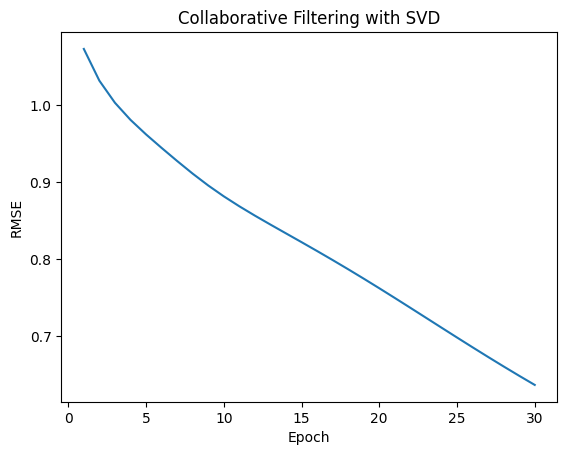

In [9]:
RMSEs = []
num_epochs = 30

for epoch in trange(num_epochs, desc='Training'):
    train(model, train_data)
    rmse = evaluate(model, validation_data)
    RMSEs.append(rmse)

print(f'Final RMSE: {RMSEs[-1]:.4f}')
plot(RMSEs)

### 2.5- Recommend

The below cell will compare the unseen ratings with the predictions.

In [13]:
def get_candidate_items(user_id):
    # TODO: return movie_ids and ratings for user_id in validation set. (≈2 lines)
    return validation_data[validation_data['userId'] == user_id]

def recommend_for_user(model, user_id):
    # TODO: return a dataframe with true and predicted ratings for user_id items in validation set. (≈10 lines)
    candidate_items = get_candidate_items(user_id)
    movie_ids = candidate_items['movieId'].values
    real_ratings = candidate_items['rating'].values

    predicted_ratings = []
    for movie_id in movie_ids:
        predicted_ratings.append(model.forward(user_id, movie_id))

    result = pd.DataFrame({
        'Item Id': movie_ids,
        'Real Rating': real_ratings,
        'Pred Rating': predicted_ratings
    })
    return result

result = recommend_for_user(model, 200)
result


,Item Id,Real Rating,Pred Rating


Good predictions! There are better techniques for collaborative filtering using neural networks. For more information see [this](https://www.nvidia.com/en-us/glossary/recommendation-system/) blog. As this blog said, recommender systems have very huge impact on the amount of sales for companies. I hope you find this notebook helpful. Thanks!